In [1]:
import numpy as np
import pylab as pl
%matplotlib inline

### Modelo y muestras aleatorias

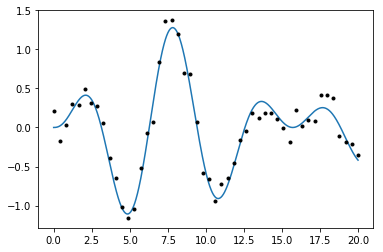

In [2]:
def f(x):
    '''
    Returns a sample with instances without noise.
    '''
    y = np.sin(x) * np.exp(-0.1*x) * np.sqrt(x) * np.sin(0.2*x)
    return (y)

def sample(x, f, noise):
    '''
    Returns a sample with 'size' instances.
    '''
    mn = np.min(f(x))
    mx = np.max(f(x))
    y = f(x) + pl.randn(x.size)*noise*(mx-mn)
    return (y)
    
pl.clf()
xmax = 20
n_show = 1000
x = np.linspace(0, xmax, n_show)
y = f(x)
pl.plot(x, y)

n_sample = 50
xs = np.linspace(0, xmax, n_sample)
ys = sample(xs, f, .05)
pl.plot(xs, ys, 'k.')

### Ajuste de modelos anidados

In [3]:
from sklearn.linear_model import LinearRegression

def fit_polynomial(x, y, degree):
    '''
    Fits a polynomial to the input sample.
    (x,y): input sample
    degree: polynomial degree
    '''
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y)
    return model

def apply_polynomial(model, x):
    '''
    Evaluates a linear regression model in an input sample
    model: linear regression model
    x: input sample
    '''
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1))
    return y

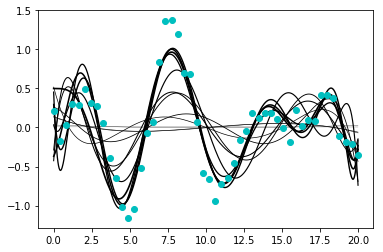

In [4]:
max_order = 14

for i in range(max_order):
    model = fit_polynomial(xs, ys, i)
    p_y = apply_polynomial(model, x)
    lwd = 0.05 + float(i)/16*2
    pl.plot(x, p_y, 'k',lw=lwd)
pl.plot(xs, ys, "co")

Veamos el error que se comete al realizar cada ajuste.  Para eso calculamos en error cuadrático medio:

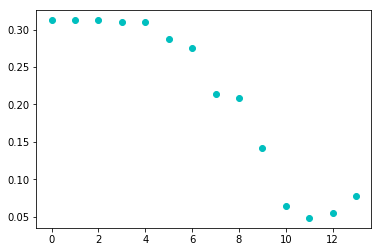

In [5]:
err = []
for i in range(max_order):
    model = fit_polynomial(xs, ys, i)
    p_y = apply_polynomial(model, xs)

    err.append(((ys - p_y)**2).mean())    

pl.plot(range(max_order), err, "co")

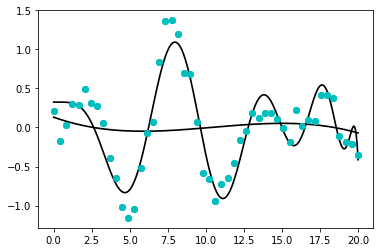

In [6]:
model = fit_polynomial(xs, ys, 3)
p_y = apply_polynomial(model, x)

pl.plot(x, p_y, 'k',lw=lwd)
pl.plot(xs, ys, "co")


model = fit_polynomial(xs, ys, 14)
p_y = apply_polynomial(model, x)

pl.plot(x, p_y, 'k',lw=lwd)
pl.plot(xs, ys, "co")

### Promedio de ajustes para varias muestras

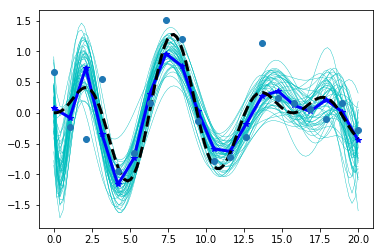

In [7]:
degree = 10
n_samples = 20
n_models = 50

avg_y = np.zeros(n_samples)

xd = np.linspace(0, xmax, 100)
xs = np.linspace(0, xmax, n_samples)

for i in xrange(n_models):
    ys = sample(xs, f, 0.15)
    model = fit_polynomial(xs, ys, degree)
    p_y = apply_polynomial(model, xs)
    avg_y = avg_y + p_y
    p_y = apply_polynomial(model, xd)
    pl.plot(xd, p_y, 'c-', lw=0.4)
avg_y = avg_y / n_models

pl.plot(xs, avg_y, '*-b',lw=3)
pl.plot(xd, f(xd), 'k--', lw=3)
pl.plot(xs, ys, 'o')

### Sesgo y varianza teóricos
Vamos a hacer una estimacion MonteCarlo de la varianza y del sesgo.  Para ello necesitamos saber el modelo verdadero.  Esta no es una situación realista, pero la vamos a usar para entender qué pasa...

In [8]:
from numpy.linalg import norm

n_samples = 40
xs = np.linspace(0, xmax, n_samples)
yt = f(xs)
n_models = 100
max_degree = 14
var_vals =[]
bias_vals = []
error_vals = []

In [9]:
for degree in xrange(1, max_degree):
    
    avg_y = np.zeros(n_samples)
    models = []
    for i in xrange(n_models):
        
        ys = sample(xs, f, 0.15)
        model = fit_polynomial(xs, ys, degree)
        p_y = apply_polynomial(model, xs)
        
        avg_y = avg_y + p_y
        models.append(p_y)
        
    avg_y = avg_y / n_models
    bias_2 = norm(avg_y - yt)/ys.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += norm(avg_y - p_y)
    variance /= ys.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)

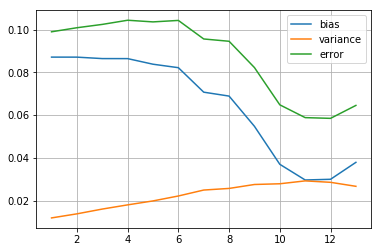

In [10]:
pl.plot(range(1, max_degree), bias_vals, label='bias')
pl.plot(range(1, max_degree), var_vals, label='variance')
pl.plot(range(1, max_degree), error_vals, label='error')
pl.grid()
pl.legend()

### Validación cruzada

En la vida real no tenemos la función, la idea es que tenemos una muestra, de la cual separamos dos submuestras, una de entrenamiento y una de validación.

In [11]:
n_samples = 50
n_train = 25

# simulamos una muestra:
x_all = np.linspace(0, xmax, n_samples)
y_all = sample(x_all, f, 0.15)

# muestras de entrenamiento y validacion:
import random

ids = random.sample(range(n_samples), n_train)

x_train = [x_all[k] for k in range(len(x_all)) if k in ids]
y_train = [y_all[k] for k in range(len(x_all)) if k in ids]

x_test = [x_all[k] for k in range(len(x_all)) if k not in ids]
y_test = [y_all[k] for k in range(len(x_all)) if k not in ids]

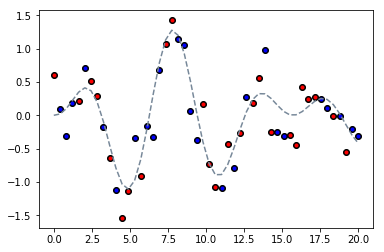

In [12]:
pl.plot(x_all, y_all, "ok")
pl.plot(x_train, y_train, ".b")
pl.plot(x_test, y_test, ".r")
pl.plot(x_all, f(x_all), color='lightslategrey', linestyle='--')

In [13]:
max_degree = 10

test_error_vals = []
train_error_vals = []

for degree in xrange(1, max_degree):
    
    model = fit_polynomial(x_train, y_train, degree)
    y_model = apply_polynomial(model, x_train)    
    train_error_vals.append( ((y_train - y_model)**2).mean() )
      
    model = fit_polynomial(x_test, y_test, degree)
    y_model = apply_polynomial(model, x_test)
    test_error_vals.append( ((y_test - y_model)**2).mean() )

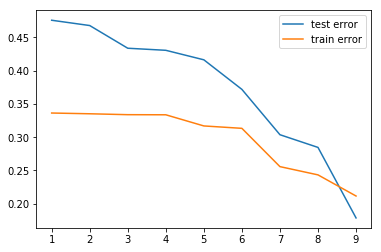

In [14]:
pl.plot(range(1, max_degree), test_error_vals, label='test error')
pl.plot(range(1, max_degree), train_error_vals, label='train error')
pl.legend()

Si hubiéramos tomado las muestras de entrenamiento y de validación de manera diferente, tendríamos seguramente otras curvas....

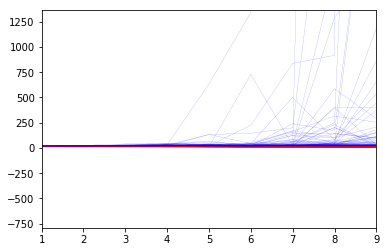

In [15]:
n_experiments = 100

x_all = np.linspace(0, xmax, n_samples)
y_all = sample(x_all, f, 0.3)

for e in range(n_experiments):

    ids = random.sample(range(n_samples), n_train)
    x_train = [x_all[k] for k in range(len(x_all)) if k in ids]
    y_train = [y_all[k] for k in range(len(x_all)) if k in ids]
    x_test = [x_all[k] for k in range(len(x_all)) if k not in ids]
    y_test = [y_all[k] for k in range(len(x_all)) if k not in ids]
    
    test_error_vals = [] 
    train_error_vals = []

    for degree in xrange(1, max_degree):
    
        model = fit_polynomial(x_train, y_train, degree)
    
        y_model = apply_polynomial(model, x_train)
        train_error_vals.append(pl.norm(y_train - y_model)**2)
        
        y_model = apply_polynomial(model, x_test)
        test_error_vals.append(pl.norm(y_test - y_model)**2)
        
    pl.plot(range(1, max_degree), train_error_vals, 'r', lw=0.1)
    pl.plot(range(1, max_degree), test_error_vals, 'b',lw=0.1)

    pl.xlim(1,max_degree-1)
    pl.grid()
    mx = np.max(test_error_vals)
    mn = np.min(test_error_vals)
    pl.ylim((mx+mn)/2-(mx-mn)*2.75,  (mx+mn)/2+(mx-mn)*3.25)

### Comportamiento promedio

In [34]:
n_samples = 200
n_train = 100
max_degree = 20

In [35]:
x = np.linspace(0, xmax, n_samples)
x_all = np.linspace(0, xmax, n_samples)
y_all = sample(x_all, f, 0.01)

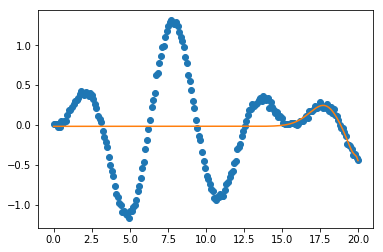

In [41]:
pl.plot(x_all, y_all, "o")

model = fit_polynomial(x_all, y_all, 50)    
y_model = apply_polynomial(model, x_all)

pl.plot(x_all, y_model)



(-6.0591772947142566, 70.464496344597691)

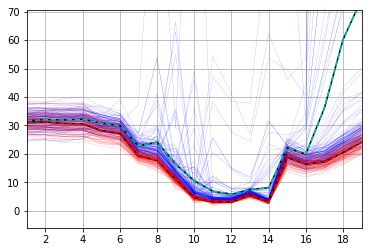

In [39]:
err_train = np.zeros(max_degree-1)
err_test = np.zeros(max_degree-1)

for e in range(n_experiments):

    ids = random.sample(range(n_samples), n_train)
    x_train = [x_all[k] for k in range(len(x_all)) if k in ids]
    y_train = [y_all[k] for k in range(len(x_all)) if k in ids]
    x_test = [x_all[k] for k in range(len(x_all)) if k not in ids]
    y_test = [y_all[k] for k in range(len(x_all)) if k not in ids]    
    test_error_vals = []; train_error_vals = []

    for degree in xrange(1, max_degree):    
        model = fit_polynomial(x_train, y_train, degree)    
        y_model = apply_polynomial(model, x_train)
        train_error_vals.append(pl.norm(y_train - y_model)**2)        
        y_model = apply_polynomial(model, x_test)
        test_error_vals.append(pl.norm(y_test - y_model)**2)        
    err_train = err_train + train_error_vals
    err_test = err_test + test_error_vals    
    pl.plot(range(1, max_degree), test_error_vals, 'b',lw=0.1)
    pl.plot(range(1, max_degree), train_error_vals, 'r', lw=0.1)
    pl.xlim(1,max_degree-1)
    pl.grid()
err_train = err_train / n_experiments
err_test = err_test / n_experiments

pl.plot(range(1, max_degree), err_test, 'k',lw=1.5)
pl.plot(range(1, max_degree), err_test, 'c--',lw=1.5)
pl.plot(range(1, max_degree), err_train, 'k',lw=1.5)
pl.plot(range(1, max_degree), err_train, 'r--',lw=1.5)
pl.grid()
mx = np.max(err_test[1:5])
mn = np.min(err_train[1:5])
pl.ylim((mx+mn)/2-(mx-mn)*9,  (mx+mn)/2+(mx-mn)*10)

In [60]:
n_samples = 10
n_train = 2
ids = random.sample(['a','b','c'], n_train)
print ids

['a', 'c']
